## Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

from datetime import date, timedelta,datetime
from dateutil import easter
from dateutil.relativedelta import *

import sklearn
import matplotlib.pyplot as plt
import calendar

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.random import set_seed

## Additional functions

In [3]:
# get holidays in given year(s)

def get_holidays(year):
    easter_sunday = easter.easter(year)
    holidays = [date(year,1,1),
                date(year,1,6),
                easter_sunday,
                easter_sunday + timedelta(days=1),
                date(year,5,1),
                date(year,5,3),
                # 7th Sunday after Easter
                # (notice days+1 - this is 7th Sunday excluding Easter Sunday
                easter_sunday + relativedelta(days=+1, weekday=SU(+7)),
                # 9th Thursday after Easter
                easter_sunday + relativedelta(weekday=TH(+9)),
                date(year,8,15),
                date(year,11,1),
                date(year,11,11),
                date(year, 12, 25),
                date(year, 12, 26),
               ]
    return holidays

## Get data

In [20]:
#gas consumption data

df = pd.read_excel("sample_data.xls", usecols=["date","value"])
df["date"] = pd.to_datetime(df["date"])
df = df[df["date"]<"2022.03.01"]

#sum hourly data to get daily consumption
df=df.set_index("date").resample("1D").sum().reset_index()


In [5]:
#get meteo data
df_meteo = pd.read_csv("2018_2022_hourly_meteo_data.csv", parse_dates=[1])

#get data for only one weather station (gas recipient's city)
df_meteo = df_meteo[df_meteo["station_id"] == 353230295]
df_meteo.info()

#get daily average temperature and wind speed 
df_d = df_meteo[["date", "temp","wind"]].set_index("date").resample("1D").mean()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36480 entries, 8264487 to 8300966
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   station_id  36480 non-null  int64         
 1   date        36480 non-null  datetime64[ns]
 2   temp        36478 non-null  float64       
 3   wind        36329 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 1.4 MB


## Features

In [22]:
def feature_engineering(df):

    #timeseries features
    df["day"] = df["date"].dt.day
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["hour"] = df["date"].dt.hour
    df["dayofweek"] = df["date"].dt.dayofweek
    df["dayofyear"] = df["date"].dt.dayofyear
    df["weekofyear"] = df["date"].dt.weekofyear
    df["is_holiday"] = df["date"].apply(lambda x: int(x in holidays))
    df["is_weekend"] = df["dayofweek"].apply(lambda x: int(x>=5))
    df["is_weekday"] = df["dayofweek"].apply(lambda x: int(x<5))
    df["quarter"]=df["date"].dt.quarter
    df["is_month_start"] = df["date"].dt.is_month_start.astype("int")
    df["is_month_end"] = df["date"].dt.is_month_end.astype("int")
    df["is_day_before_holiday"] = df["date"].apply(lambda x: int(x+timedelta(days=1) in holidays))
    df["is_day_after_holiday"] = df["date"].apply(lambda x: int(x-timedelta(days=1) in holidays))
    
    
  #meteo
    df["date_avg_temp"] = df["date"].apply(lambda x: df_d.loc[x, "temp"])
    df["date_avg_wind"] = df["date"].apply(lambda x: df_d.loc[x, "wind"])

  #additional 0/1 columns for month and day  
    for i,m in enumerate(calendar.month_name[1:]):
        df[m] = df["month"].map(lambda x: int(x == i+1))
    
    for i,d in enumerate(calendar.day_name[:]):
        df[d] = df["dayofweek"].map(lambda x: int(x == i))

    return df
    


In [23]:
holidays = [get_holidays(x) for x in range(2018,2023)]
holidays = [i for sublist in holidays for i in sublist]
df_new = feature_engineering(df.copy()).reset_index()

C:\Users\pawel.piekaj\AppData\Local\Temp\ipykernel_22272\1445798358.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["weekofyear"] = df["date"].dt.weekofyear
C:\Users\pawel.piekaj\AppData\Local\Temp\ipykernel_22272\1445798358.py:11: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df["is_holiday"] = df["date"].apply(lambda x: int(x in holidays))
C:\Users\pawel.piekaj\AppData\Local\Temp\ipykernel_22272\1445798358.py:17: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df["is_day_before_holiday"] = df["date"].a

## X i y

In [25]:
feats = [ "day", "month", "dayofweek", "dayofyear", "weekofyear","quarter"]
feats+= ["date_avg_temp","date_avg_wind"]
feats += ["is_holiday","is_month_start","is_month_start","is_weekend","is_weekday","is_day_before_holiday","is_day_after_holiday"]
feats+= calendar.month_name[1:]
feats+= calendar.day_name[:]


df_test = df_new[(df_new["date"]>="2021.11.01") & (df["date"]<"2022.03.01")].copy()
df_train = df_new[(df_new["date"]>="2019.01.01") & (df["date"]<"2021.11.01") ].copy()
df_test_cp = df_test.copy()
df_test["value"] = np.nan

X_train = df_train[feats].values
y_train = df_train["value"].values
X_test = df_test[feats].values


## neural network

In [28]:
set_seed(0)


model = Sequential()
model.add( Dense(34, input_shape=(34,), activation="linear") ) # input layer
model.add( Dense(17, activation="relu") ) # hidden layer
model.add( Dense(1, activation="elu") ) # output layer


model.compile(optimizer="adam", loss="mse", metrics=["mae"])

result = model.fit(X_train, y_train, epochs=200, verbose=1, validation_split=.05 )

Epoch 1/200
31/31 [==============================] - 1s 9ms/step - loss: 487.4362 - mae: 16.8340 - val_loss: 150.6184 - val_mae: 9.6217
Epoch 2/200
31/31 [==============================] - 0s 3ms/step - loss: 376.0276 - mae: 14.3943 - val_loss: 187.2307 - val_mae: 10.8666
Epoch 3/200
31/31 [==============================] - 0s 3ms/step - loss: 312.0876 - mae: 13.1293 - val_loss: 150.3500 - val_mae: 9.2578
Epoch 4/200
31/31 [==============================] - 0s 3ms/step - loss: 258.2921 - mae: 12.0623 - val_loss: 110.4010 - val_mae: 7.7534
Epoch 5/200
31/31 [==============================] - 0s 3ms/step - loss: 217.5029 - mae: 11.2351 - val_loss: 132.0294 - val_mae: 8.4063
Epoch 6/200
31/31 [==============================] - 0s 3ms/step - loss: 189.3488 - mae: 10.6308 - val_loss: 110.9641 - val_mae: 7.6598
Epoch 7/200
31/31 [==============================] - 0s 3ms/step - loss: 161.0997 - mae: 9.7749 - val_loss: 113.0157 - val_mae: 7.6939
Epoch 8/200
31/31 [=============================

In [29]:
y_pred = model.predict(X_test)

<AxesSubplot:>

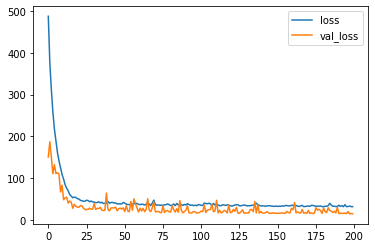

In [30]:
df1 = pd.DataFrame( result.history )
df1[ ["loss","val_loss"] ].plot()

In [31]:
df_test_cp["pred_value"] = y_pred
mean_absolute_error(df_test_cp.value, df_test_cp.pred_value)

4.51547561009725

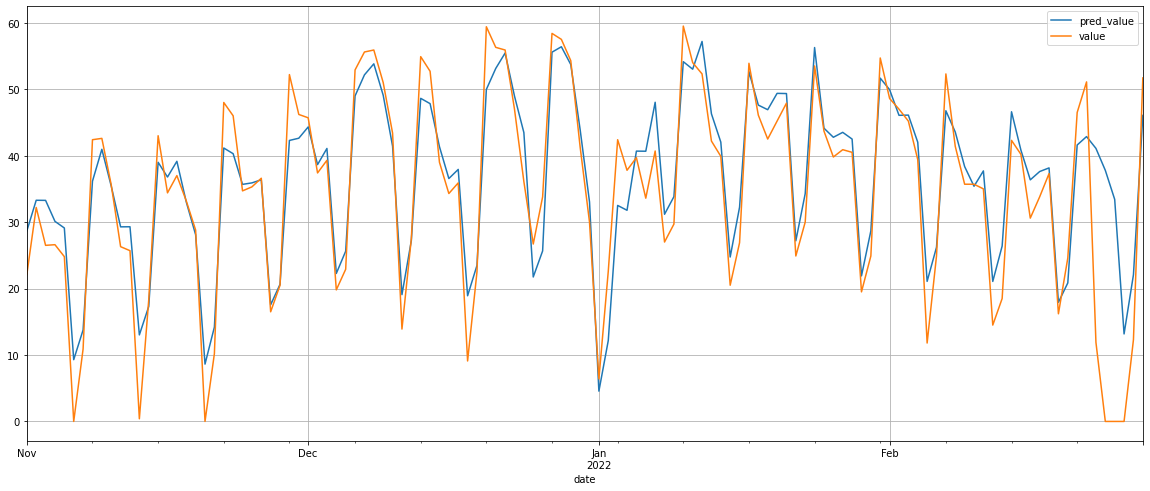

In [33]:
df_plot = df_test_cp.set_index("date")
df_plot["pred_value"].plot()
df_plot["value"].plot( figsize=(20,8), grid=True )
plt.legend();